<a href="https://colab.research.google.com/github/crk00015/Final-project-team-13/blob/main/casey_group1_brief.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import random
import time
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from torchvision import models, transforms
import torch

categories = ["good", "poor", "satisfactory", "very_poor"]
label_map = {label: idx for idx, label in enumerate(categories)}

base_path = "/content/drive/MyDrive/Final Project 465/lab2/PICs/sih_road_dataset"
image_files, labels = [], []
for category in categories:
    cat_path = os.path.join(base_path, category)
    files = [os.path.join(cat_path, f) for f in os.listdir(cat_path)]
    sample = random.sample(files, min(150, len(files)))
    image_files += sample
    labels += [category] * len(sample)
train_files, temp_files, train_labels, temp_labels = train_test_split(image_files, labels, test_size=0.2, stratify=labels, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

fast = cv2.FastFeatureDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

def extract_brief(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    kp = fast.detect(img, None)
    kp, des = brief.compute(img, kp)
    return np.mean(des, axis=0) if des is not None else np.zeros(64)

def compute_features(paths, labels):
    features = []
    targets = []
    start_time = time.time()
    for i, (path, label) in enumerate(zip(paths, labels)):
        print(f"[{i+1}/{len(paths)}] Processing BRIEF for: {os.path.basename(path)}")
        feat = extract_brief(path)
        features.append(feat)
        targets.append(label_map[label])
    return np.array(features), np.array(targets)

X_train, y_train = compute_features(train_files, train_labels)
X_val, y_val = compute_features(val_files, val_labels)
X_test, y_test = compute_features(test_files, test_labels)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Training SVM on BRIEF features")
svm_brief = SVC(kernel='linear', probability=True)
svm_brief.fit(X_train_scaled, y_train)

densenet = models.densenet121(pretrained=True)
densenet.classifier = torch.nn.Identity()
densenet.eval()
deep_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def extract_densenet_features(paths, labels):
    features = []
    targets = []
    start_time = time.time()
    for i, (path, label) in enumerate(zip(paths, labels)):
        print(f"[{i+1}/{len(paths)}] Extracting DenseNet features from: {os.path.basename(path)}")
        try:
            img = Image.open(path).convert("RGB")
            x = deep_transform(img).unsqueeze(0)
            with torch.no_grad():
                feat = densenet(x).squeeze().numpy()
            features.append(feat)
            targets.append(label_map[label])
        except Exception as e:
            print(f"Failed on {path}: {e}")
            features.append(np.zeros(1024))
            targets.append(0)
    return np.array(features), np.array(targets)

X_train_deep, y_train_deep = extract_densenet_features(train_files, train_labels)
X_val_deep, y_val_deep = extract_densenet_features(val_files, val_labels)
X_test_deep, y_test_deep = extract_densenet_features(test_files, test_labels)

scaler_deep = StandardScaler()
X_train_deep = scaler_deep.fit_transform(X_train_deep)
X_val_deep = scaler_deep.transform(X_val_deep)
X_test_deep = scaler_deep.transform(X_test_deep)

print("Training SVM on DenseNet features")
svm_deep = SVC(kernel='linear', probability=True)
svm_deep.fit(X_train_deep, y_train_deep)

def evaluate_svm(model, X, y):
    preds = model.predict(X)
    return {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, average='macro'),
        "recall": recall_score(y, preds, average='macro'),
        "f1": f1_score(y, preds, average='macro')
    }

print("Results")
print("BRIEF and SVM:", evaluate_svm(svm_brief, X_test_scaled, y_test))
print("DenseNet and SVM:", evaluate_svm(svm_deep, X_test_deep, y_test_deep))


[1/457] Processing BRIEF for: good_056.JPG
[2/457] Processing BRIEF for: good_754.JPG
[3/457] Processing BRIEF for: poor_269.jpg
[4/457] Processing BRIEF for: satis_309.jpg
[5/457] Processing BRIEF for: good_386.JPG
[6/457] Processing BRIEF for: poor_358.jpg
[7/457] Processing BRIEF for: verypoor_026.jpg
[8/457] Processing BRIEF for: poor_314.jpg
[9/457] Processing BRIEF for: poor_109.jpg
[10/457] Processing BRIEF for: poor_258.jpg
[11/457] Processing BRIEF for: good_124.JPG
[12/457] Processing BRIEF for: good_252.JPG
[13/457] Processing BRIEF for: poor_035.jpg
[14/457] Processing BRIEF for: satis_444.jpg
[15/457] Processing BRIEF for: good_369.JPG
[16/457] Processing BRIEF for: poor_313.jpg
[17/457] Processing BRIEF for: satis_382.jpg
[18/457] Processing BRIEF for: satis_440.jpg
[19/457] Processing BRIEF for: satis_115.jpg
[20/457] Processing BRIEF for: good_630.JPG
[21/457] Processing BRIEF for: good_601.JPG
[22/457] Processing BRIEF for: verypoor_108.jpg
[23/457] Processing BRIEF fo

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1/457] Extracting DenseNet features from: good_056.JPG
[2/457] Extracting DenseNet features from: good_754.JPG
[3/457] Extracting DenseNet features from: poor_269.jpg
[4/457] Extracting DenseNet features from: satis_309.jpg
[5/457] Extracting DenseNet features from: good_386.JPG
[6/457] Extracting DenseNet features from: poor_358.jpg
[7/457] Extracting DenseNet features from: verypoor_026.jpg
[8/457] Extracting DenseNet features from: poor_314.jpg
[9/457] Extracting DenseNet features from: poor_109.jpg
[10/457] Extracting DenseNet features from: poor_258.jpg
[11/457] Extracting DenseNet features from: good_124.JPG
[12/457] Extracting DenseNet features from: good_252.JPG
[13/457] Extracting DenseNet features from: poor_035.jpg
[14/457] Extracting DenseNet features from: satis_444.jpg
[15/457] Extracting DenseNet features from: good_369.JPG
[16/457] Extracting DenseNet features from: poor_313.jpg
[17/457] Extracting DenseNet features from: satis_382.jpg
[18/457] Extracting DenseNet feat

Training SVM on BRIEF features


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 126MB/s]


Training SVM on DenseNet features
Results
BRIEF and SVM: {'accuracy': 0.7068965517241379, 'precision': 0.7171130952380953, 'recall': 0.7089743589743589, 'f1': 0.7044227218420767}
DenseNet and SVM: {'accuracy': 0.9310344827586207, 'precision': 0.9473684210526316, 'recall': 0.9333333333333333, 'f1': 0.9321266968325792}


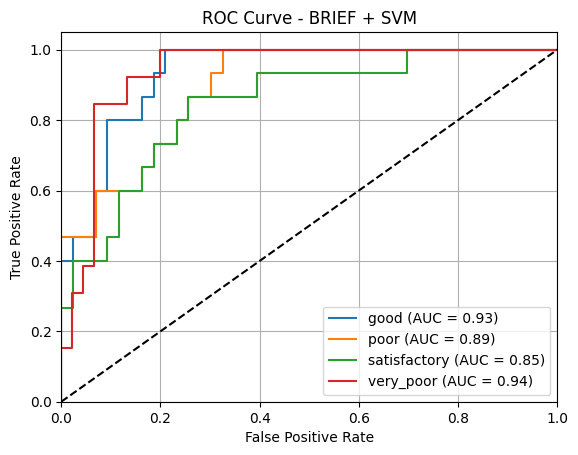

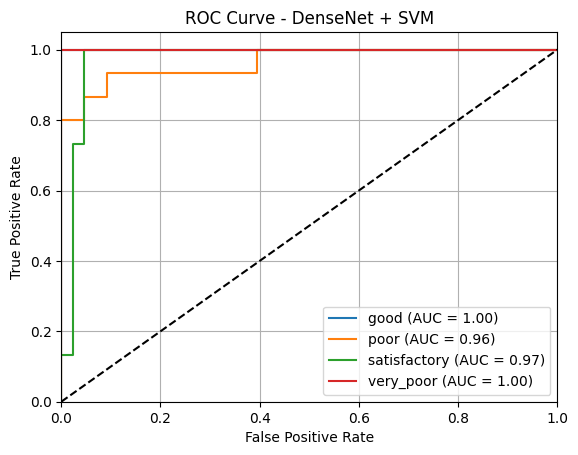

In [2]:
import os
import random
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from torchvision import models, transforms
import torch

categories = ["good", "poor", "satisfactory", "very_poor"]
label_map = {label: idx for idx, label in enumerate(categories)}

base_path = "/content/drive/MyDrive/Final Project 465/lab2/PICs/sih_road_dataset"
image_files, labels = [], []
for category in categories:
    cat_path = os.path.join(base_path, category)
    files = [os.path.join(cat_path, f) for f in os.listdir(cat_path)]
    sample = random.sample(files, min(150, len(files)))
    image_files += sample
    labels += [category] * len(sample)
train_files, temp_files, train_labels, temp_labels = train_test_split(image_files, labels, test_size=0.2, stratify=labels, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

fast = cv2.FastFeatureDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

def extract_brief(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    kp = fast.detect(img, None)
    kp, des = brief.compute(img, kp)
    return np.mean(des, axis=0) if des is not None else np.zeros(64)

def compute_features(paths, labels, extractor):
    features = []
    targets = []
    for path, label in zip(paths, labels):
        feat = extractor(path)
        features.append(feat)
        targets.append(label_map[label])
    return np.array(features), np.array(targets)

X_train, y_train = compute_features(train_files, train_labels, extract_brief)
X_val, y_val = compute_features(val_files, val_labels, extract_brief)
X_test, y_test = compute_features(test_files, test_labels, extract_brief)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Training SVM on BRIEF features")
svm_brief = OneVsRestClassifier(SVC(kernel='linear', probability=True))
svm_brief.fit(X_train_scaled, y_train)

densenet = models.densenet121(pretrained=True)
densenet.classifier = torch.nn.Identity()
densenet.eval()
deep_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def extract_densenet_features(paths, labels):
    features = []
    targets = []
    for path, label in zip(paths, labels):
        try:
            img = Image.open(path).convert("RGB")
            x = deep_transform(img).unsqueeze(0)
            with torch.no_grad():
                feat = densenet(x).squeeze().numpy()
            features.append(feat)
            targets.append(label_map[label])
        except:
            features.append(np.zeros(1024))
            targets.append(0)
    return np.array(features), np.array(targets)

X_train_deep, y_train_deep = extract_densenet_features(train_files, train_labels)
X_val_deep, y_val_deep = extract_densenet_features(val_files, val_labels)
X_test_deep, y_test_deep = extract_densenet_features(test_files, test_labels)

scaler_deep = StandardScaler()
X_train_deep = scaler_deep.fit_transform(X_train_deep)
X_val_deep = scaler_deep.transform(X_val_deep)
X_test_deep = scaler_deep.transform(X_test_deep)

print("Training SVM on DenseNet features")
svm_deep = OneVsRestClassifier(SVC(kernel='linear', probability=True))
svm_deep.fit(X_train_deep, y_train_deep)

def evaluate_svm(model, X, y):
    preds = model.predict(X)
    return {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, average='macro'),
        "recall": recall_score(y, preds, average='macro'),
        "f1": f1_score(y, preds, average='macro')
    }

def plot_roc(model, X, y, title):
    lb = LabelBinarizer()
    y_bin = lb.fit_transform(y)
    y_score = model.predict_proba(X)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(categories)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_bin[:, i], y_score[:, i])
    plt.figure()
    for i in range(len(categories)):
        plt.plot(fpr[i], tpr[i], label=f"{categories[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

print("Results")
print("BRIEF and SVM:", evaluate_svm(svm_brief, X_test_scaled, y_test))
print("DenseNet and SVM:", evaluate_svm(svm_deep, X_test_deep, y_test_deep))

plot_roc(svm_brief, X_test_scaled, y_test, "BRIEF + SVM")
plot_roc(svm_deep, X_test_deep, y_test_deep, "DenseNet + SVM")
